In [77]:
import pandas as pd
import pyarrow
import gzip
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import folium
import numpy as np
import seaborn as sns
from IPython.display import display, HTML
display(HTML("<style>div.output_scroll { height: auto !important; max-height: none !important; }</style>"))

In [78]:
rutas = '../Variables_entorno/rutas.txt'

In [79]:
with open(rutas, 'r') as archivo:
    for linea in archivo.readlines():
        exec(linea.strip(), globals())

Analizamos el diccionario de datos y sabemos qué columnas vamos a borrar. Vamos a hacer un EDA para un dataset de cada clase y, en base a eso, creamos una función para trabajar con los otros.

In [80]:
df_amarillos_12_19 = pd.read_parquet(amarillos_12_19, engine='pyarrow')
# df_verdes_12_19 = pd.read_parquet(verdes_12_19, engine='pyarrow')
# df_alquiler_12_19 = pd.read_parquet(alquiler_12_19, engine='pyarrow')
# df_alquiler_hv_12_19 = pd.read_parquet(alquiler_hv_12_19, engine='pyarrow')

In [81]:
df_amarillos_12_19.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

# ETL Taxis amarillos

Observando el diccionario de datos, decidimos borrar algunas columnas. Las que dejamos sirven para un análisis de rentabilidad y, además, 'congestion_surcharge' nos da un indicador indirecto del tráfico. Esta columna es un recargo por congestión.

In [82]:
nuevos_nombres = {'tpep_pickup_datetime': 'inicio_viaje', 'tpep_dropoff_datetime': 'fin_viaje', 'passenger_count': 'pasajeros',
                  'trip_distance': 'distancia', 'PULocationID': 'zona_inicio', 'DOLocationID': 'zona_fin', 'fare_amount': 'tarifa_medida',
                  'total_amount': 'tarifa_total', 'congestion_surcharge': 'recargo_trafico', 'payment_type': 'modalidad_pago',
                  'tip_amount': 'propina', 'lpep_pickup_datetime': 'inicio_viaje', 'lpep_dropoff_datetime': 'fin_viaje'}

In [83]:
df_amarillos_12_19.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

In [84]:
df_amarillos_12_19.rename(columns=nuevos_nombres, inplace=True)

In [85]:
columnas_a_borrar = []
for columna in df_amarillos_12_19.columns:
    if columna not in nuevos_nombres.values():
        columnas_a_borrar.append(columna)

In [86]:
df_amarillos_12_19.drop(columnas_a_borrar, axis=1, inplace=True)

In [87]:
df_amarillos_12_19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6896317 entries, 0 to 6896316
Data columns (total 11 columns):
 #   Column           Dtype         
---  ------           -----         
 0   inicio_viaje     datetime64[ns]
 1   fin_viaje        datetime64[ns]
 2   pasajeros        float64       
 3   distancia        float64       
 4   zona_inicio      int64         
 5   zona_fin         int64         
 6   modalidad_pago   int64         
 7   tarifa_medida    float64       
 8   propina          float64       
 9   tarifa_total     float64       
 10  recargo_trafico  float64       
dtypes: datetime64[ns](2), float64(6), int64(3)
memory usage: 578.8 MB


## Transformamos datos mal cargados:

Avanzando con el EDA nos econtramos con valores negativos en varias columnas. Antes de convertir los NaN a -1, normalizamos esos valores.

In [88]:
def positivos(valor:float|int) -> float|int:
    if type(valor) == float:
        return float(abs(valor))
    else:
        return int(abs(valor))

In [89]:
for columna in df_amarillos_12_19.columns[2:]:
    df_amarillos_12_19[columna] = df_amarillos_12_19[columna].apply(positivos)


## Verificamos nulos o faltantes en cada columna:

In [90]:
def revision_nulos(data:pd.DataFrame) -> dict:
    porcentaje_nulos_dict = {}
    for columna in data.columns:
        nulos = data[columna].isnull().sum()
        total = len(data[columna])
        porcentaje = round(nulos/total*100,2)
        porcentaje_nulos_dict[columna] = porcentaje
        print(f'\nColumna: {columna:<20}      Cantidad de nulos: {nulos:<7}      Porcentaje de nulos: {str(porcentaje) + " %":<8}\n')
    return porcentaje_nulos_dict


In [91]:
nulos_dict = revision_nulos(df_amarillos_12_19)


Columna: inicio_viaje              Cantidad de nulos: 0            Porcentaje de nulos: 0.0 %   


Columna: fin_viaje                 Cantidad de nulos: 0            Porcentaje de nulos: 0.0 %   


Columna: pasajeros                 Cantidad de nulos: 51018        Porcentaje de nulos: 0.74 %  


Columna: distancia                 Cantidad de nulos: 0            Porcentaje de nulos: 0.0 %   


Columna: zona_inicio               Cantidad de nulos: 0            Porcentaje de nulos: 0.0 %   


Columna: zona_fin                  Cantidad de nulos: 0            Porcentaje de nulos: 0.0 %   


Columna: modalidad_pago            Cantidad de nulos: 0            Porcentaje de nulos: 0.0 %   


Columna: tarifa_medida             Cantidad de nulos: 0            Porcentaje de nulos: 0.0 %   


Columna: propina                   Cantidad de nulos: 0            Porcentaje de nulos: 0.0 %   


Columna: tarifa_total              Cantidad de nulos: 0            Porcentaje de nulos: 0.0 %   


Columna: 

Dado que todas las columnas son numéricas (salvo fecha), los nulos de esas columnas los reemplazamos por -1. Si hay nulos en fechas, por el momento, los dejamos así. Las columnas 'pasajeros', 'zona_inicio' y 'zona_fin' tienen que ser enteros, el resto float.

Si el porcentaje de nulos es menor al 10 %, se reemplazarán los valores nulos con la mediana de la columna. Si es mayor, los nulos tomarán valor de -1.
Esto se aplica a todas las columnas numéricas menos 'zona_inicio' y 'zona_fin', ya que estas representan una numeración que se relaciona con los datos del mapa. Si las columnas mencionadas contienen NaN, se reemplazarán estos valores por -1.

In [92]:
def reemplazar_nan_float(valor:float) -> float:
    if pd.isnull(valor):
        return float(-1)
    else:
        return float(valor)

In [93]:
def reemplazar_nan_int(valor:float) -> int:
    if pd.isnull(valor):
        return int(-1)
    else:
        return int(valor)

In [94]:
def mediana_columna_float(data:pd.Series) -> float:
    return float(round(data.median(), 2))


In [95]:
def mediana_columna_int(data:pd.Series) -> int:
    return int(data.median())

In [96]:
def reemplazar_nan_mediana_int(columna:str, data:pd.DataFrame) -> None:
    mediana = mediana_columna_int(data[columna][~data[columna].isnull()])
    def mediana_f(valor:float) -> int:
        if pd.isnull(valor):
            return int(mediana)
        else:
            return int(valor)
    data[columna] = data[columna].apply(mediana_f)


In [97]:
def reemplazar_nan_mediana_float(columna:str, data:pd.DataFrame) -> None:
    mediana = mediana_columna_float(data[columna][~data[columna].isnull()])
    def mediana_f(valor:float) -> float:
        if pd.isnull(valor):
            return float(mediana)
        else:
            return float(valor)
    data[columna] = data[columna].apply(mediana_f)


In [98]:
for columna in df_amarillos_12_19.columns[2:]:
    if df_amarillos_12_19[columna].isnull().sum() == 0:
        continue
    else:
        if columna == 'zona_inicio' or columna == 'zona_fin':
            df_amarillos_12_19[columna] = df_amarillos_12_19[columna].apply(reemplazar_nan_int)
        elif columna == 'pasajeros':
            if nulos_dict[columna] >= 10:
                df_amarillos_12_19[columna] = df_amarillos_12_19[columna].apply(reemplazar_nan_int)
            else:
                reemplazar_nan_mediana_int(columna, df_amarillos_12_19)
        else:
            if nulos_dict[columna] >= 10:
                df_amarillos_12_19[columna] = df_amarillos_12_19[columna].apply(reemplazar_nan_float)
            else:
                reemplazar_nan_mediana_float(columna, df_amarillos_12_19)





In [99]:
df_amarillos_12_19.head()

,inicio_viaje,fin_viaje,pasajeros,distancia,zona_inicio,zona_fin,modalidad_pago,tarifa_medida,propina,tarifa_total,recargo_trafico
0,2019-12-01 00:26:58,2019-12-01 00:41:45,1,4.2,142,116,2,14.5,0.0,18.3,2.5
1,2019-12-01 00:12:08,2019-12-01 00:12:14,1,0.0,145,145,2,2.5,0.0,3.8,0.0
2,2019-12-01 00:25:53,2019-12-01 00:26:04,1,0.0,145,145,2,2.5,0.0,3.8,0.0
3,2019-12-01 00:12:03,2019-12-01 00:33:19,2,9.4,138,25,1,28.5,10.0,39.8,0.0
4,2019-12-01 00:05:27,2019-12-01 00:16:32,2,1.6,161,237,2,9.0,0.0,12.8,2.5


## Verificamos duplicados:

In [100]:
def revision_duplicados_amarillos(data:pd.DataFrame) -> None:
    duplicados = data.duplicated().sum()
    total = len(data)
    porcentaje = round(duplicados/total*100,2)
    print(f'\nCantidad de duplicados: {duplicados:<7}      Porcentaje de duplicados: {str(porcentaje) + " %":<8}\n')
    if duplicados > 0:
         data = data.drop_duplicates()
         print(f'Se eliminaron {duplicados} registros duplicados.')


In [101]:
revision_duplicados_amarillos(df_amarillos_12_19)


Cantidad de duplicados: 3166         Porcentaje de duplicados: 0.05 %  

Se eliminaron 3166 registros duplicados.


## Verificamos outliers:

In [102]:
columnas_outliers = []
def verificar_outliers(data: pd.DataFrame) -> None:
    for columna in data.columns[2:]:
        omitir_columnas = ['zona_inicio', 'zona_fin', 'modalidad_pago', 'hora_inicio', 'hora_fin']
        if columna in omitir_columnas:
            continue
        q1 = data[columna][data[columna] > -1].quantile(0.25)
        q3 = data[columna][data[columna] > -1].quantile(0.75)
        iqr = q3 - q1
        modal = ''
        for valor in data[columna][data[columna] > -1].mode().to_list():
            modal += str(valor) + ', '
        modal = modal[:-2]
        promedio = round(data[columna][data[columna] > -1].mean(), 2)
        mediana = round(data[columna][data[columna] > -1].median(), 2)
        limite_superior = round(q3 + 1.5 * iqr, 2)
        limite_inferior = round(q1 - 1.5 * iqr, 2)
        if limite_inferior < 0:
            limite_inferior = 0
        outliers = data[columna][(data[columna] > limite_superior) | (data[columna] < limite_inferior)].count()
        if outliers > 0:
            columnas_outliers.append({'Columna': columna, 'Cantidad de outliers': outliers,
                                    'Límite inferior': limite_inferior, 'Límite superior': limite_superior,
                                    'Índices': data[(data[columna] < limite_inferior) | (data[columna] > limite_superior)].index.to_list()})
        print(f'\nColumna: {columna:<20}\n\nModal: {modal:<24} Promedio: {promedio:<24} Mediana: {mediana:<24}\n\nLímite inferior: {limite_inferior:<14} Límite superior: {limite_superior:<17} Outliers: {outliers:<16}\n\n')
        bins = (int(data[columna].max() +1) if data[columna].max() <= 40 else 40)
        plt.figure(figsize=(3,3))
        plt.hist(data[columna][data[columna] > -1], bins=bins, edgecolor='black')
        plt.title(f'Histograma de {columna}')
        plt.xlabel('Valor')
        plt.ylabel('Frecuencia')
        plt.show()
        print('\n\n')
        plt.figure(figsize=(3,3))
        plt.boxplot(data[columna][data[columna] > -1])
        plt.title(f'Boxplot de {columna}')
        plt.xlabel('Valor')
        plt.ylabel('Frecuencia')
        plt.show()
        print('\n\n\n\n')


Columna: pasajeros           

Modal: 1                        Promedio: 1.55                     Mediana: 1.0                     

Límite inferior: 0              Límite superior: 3.5               Outliers: 557822          




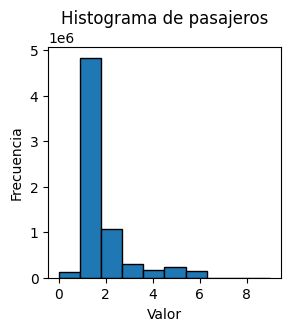

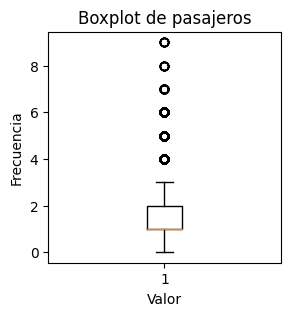







Columna: distancia           

Modal: 0.8                      Promedio: 2.99                     Mediana: 1.6                     

Límite inferior: 0              Límite superior: 6.14              Outliers: 801596          




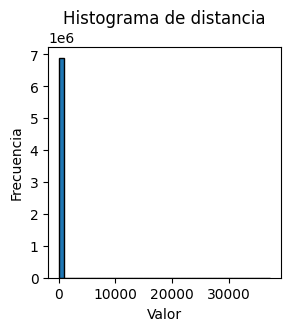

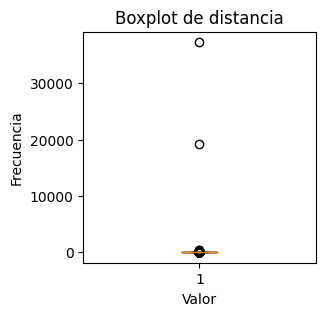







Columna: tarifa_medida       

Modal: 6.0                      Promedio: 13.67                    Mediana: 9.5                     

Límite inferior: 0              Límite superior: 29.0              Outliers: 589655          




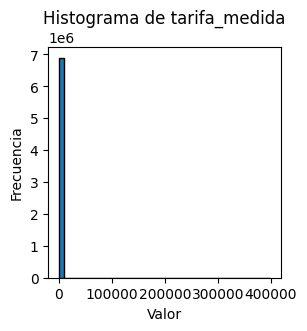

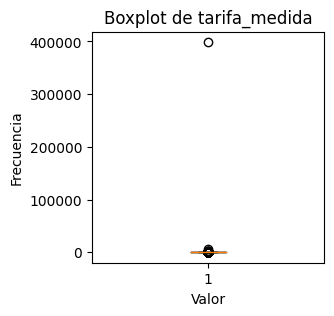







Columna: propina             

Modal: 0.0                      Promedio: 2.24                     Mediana: 1.92                    

Límite inferior: 0              Límite superior: 7.5               Outliers: 325100          




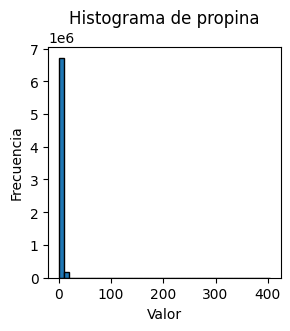

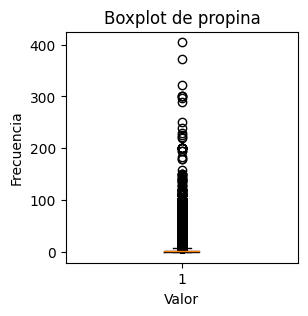







Columna: tarifa_total        

Modal: 9.8                      Promedio: 19.74                    Mediana: 14.8                    

Límite inferior: 0              Límite superior: 36.43             Outliers: 643178          




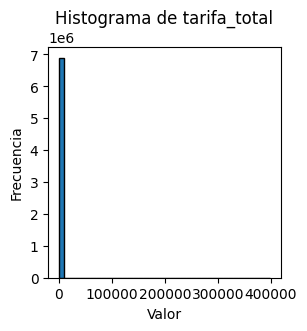

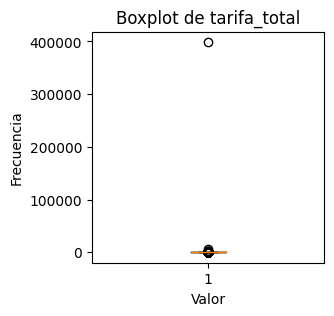







Columna: recargo_trafico     

Modal: 2.5                      Promedio: 2.31                     Mediana: 2.5                     

Límite inferior: 2.5            Límite superior: 2.5               Outliers: 535754          




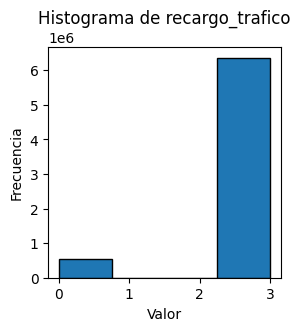

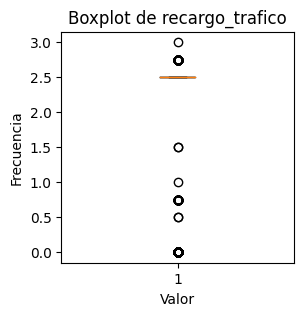

In [103]:
verificar_outliers(df_amarillos_12_19)

Vemos que hay varias cosas para revisar, por lo que debemos hacer un EDA más profundo para cada columna. Después hay que hacer una función para solucionar esos problemas y volver a revisar la función de outliers.

In [104]:
# for columna in df_amarillos_12_19.columns[2:]:
#     print('\n\n')
#     print(df_amarillos_12_19[columna][df_amarillos_12_19[columna] < 0])


Vemos que hay muchos valores negativos. Primero hay que pasarlos a positivos y después convertir a -1 los NaN. Tiene que ser en ese orden para que no existan errores.

Replanteamos la transformación de datos, agregando el paso de pasar a positivos antes de la verificación de nulos.

## Exploración de outlier:

Vemos que hay muchos valores atípicos, por lo que es necesario hacer una exploración más profunda de las columnas con problemas. Para una primera revisión tomamos los valores de límite superior calculados analíticamente y luego veremos el ajuste de los rangos correspondientes.

### Columna 'pasajeros'

In [105]:
df_amarillos_12_19[df_amarillos_12_19['pasajeros'] >= 3.5].sample(5)

,inicio_viaje,fin_viaje,pasajeros,distancia,zona_inicio,zona_fin,modalidad_pago,tarifa_medida,propina,tarifa_total,recargo_trafico
1279698,2019-12-06 14:35:28,2019-12-06 14:44:36,6,0.71,113,113,1,7.0,2.06,12.36,2.5
4039151,2019-12-17 13:39:15,2019-12-17 13:47:37,6,0.86,148,211,2,7.0,0.00,10.30,2.5
6628386,2019-12-30 18:01:23,2019-12-30 18:16:33,4,2.58,236,142,1,12.0,3.26,19.56,2.5
773660,2019-12-04 16:02:24,2019-12-04 16:07:10,6,0.81,186,90,1,5.0,1.86,11.16,2.5
5420796,2019-12-23 03:55:18,2019-12-23 04:17:41,4,3.40,230,144,2,15.5,0.00,18.80,2.5


Vemos que hay registros con 5 o más pasajeros. Al no tener referncias sobre los vehículos, vamos a tomar 4 como el máximo permitido por norma en autos nuevos. Si es mayor, le asignamos -1.

In [106]:
def limite_pasajeros(cantidad:int) -> int:
    if cantidad > 4:
        return int(-1)
    else:
        return int(cantidad)

In [107]:
df_amarillos_12_19['pasajeros'] = df_amarillos_12_19['pasajeros'].apply(limite_pasajeros)

### Columna 'distancia'

En los gráficos podemos ver que en esta columna, claramente, hay valores erróneos.

In [108]:
df_amarillos_12_19['distancia'][df_amarillos_12_19['distancia'] > 20].nunique()

2571

In [109]:
df_amarillos_12_19['distancia'][df_amarillos_12_19['distancia'] > 100].unique()

array([  117.83,   139.38, 19130.18,   103.1 ,   234.5 ,   206.72,
         125.38,   323.81,   124.  ,   109.9 ,   106.39,   248.6 ,
         119.59,   110.67,   173.5 ,   101.1 ,   163.3 ,   122.47,
         363.13,   127.98,   171.05,   300.8 ,   125.5 , 37264.53])

Chequeamos algunos valores erróneos:

In [110]:
df_amarillos_12_19[df_amarillos_12_19['distancia'] > 19000]

,inicio_viaje,fin_viaje,pasajeros,distancia,zona_inicio,zona_fin,modalidad_pago,tarifa_medida,propina,tarifa_total,recargo_trafico
704581,2019-12-04 10:20:13,2019-12-04 10:24:43,1,19130.18,224,224,2,11.00,0.0,11.00,0.0
6866810,2019-12-13 18:55:00,2019-12-13 19:44:00,1,37264.53,193,61,0,25.81,0.0,32.11,2.5


Borramos estos registros.

In [111]:
df_amarillos_12_19 = df_amarillos_12_19.drop(df_amarillos_12_19[df_amarillos_12_19['distancia'] > 19000].index)

Vemos valores más chicos pero extraños.

In [112]:
df_amarillos_12_19['distancia'][df_amarillos_12_19['distancia'] > 100].nunique()

22

In [113]:
df_amarillos_12_19['distancia'][df_amarillos_12_19['distancia'] > 100].unique()

array([117.83, 139.38, 103.1 , 234.5 , 206.72, 125.38, 323.81, 124.  ,
       109.9 , 106.39, 248.6 , 119.59, 110.67, 173.5 , 101.1 , 163.3 ,
       122.47, 363.13, 127.98, 171.05, 300.8 , 125.5 ])

In [114]:
df_amarillos_12_19[df_amarillos_12_19['distancia'] > 100].sample(3)

,inicio_viaje,fin_viaje,pasajeros,distancia,zona_inicio,zona_fin,modalidad_pago,tarifa_medida,propina,tarifa_total,recargo_trafico
2121568,2019-12-09 21:17:33,2019-12-10 02:55:18,4,323.81,130,265,2,400.0,0.0,526.30,0.0
267425,2019-12-02 13:43:39,2019-12-02 16:39:57,-1,117.83,132,265,2,544.5,0.0,561.92,0.0
1666090,2019-12-07 21:50:10,2019-12-07 23:53:34,1,125.38,132,265,1,330.0,5.0,335.80,0.0


Hay algunos valores que parecen erróneos. Revisamos todos.

In [115]:
df_amarillos_12_19[df_amarillos_12_19['distancia'] > 100]

,inicio_viaje,fin_viaje,pasajeros,distancia,zona_inicio,zona_fin,modalidad_pago,tarifa_medida,propina,tarifa_total,recargo_trafico
267425,2019-12-02 13:43:39,2019-12-02 16:39:57,-1,117.83,132,265,2,544.50,0.00,561.92,0.0
322638,2019-12-02 17:47:45,2019-12-02 22:17:48,1,139.38,168,188,2,609.50,0.00,636.06,2.5
876948,2019-12-04 23:48:12,2019-12-05 01:43:09,1,103.10,186,265,1,365.00,30.00,395.30,0.0
1164308,2019-12-06 00:37:57,2019-12-06 04:31:05,2,234.50,100,265,1,650.00,20.00,743.30,2.5
1466028,2019-12-07 04:19:20,2019-12-07 07:37:43,1,206.72,230,265,1,450.00,0.00,488.30,2.5
1666090,2019-12-07 21:50:10,2019-12-07 23:53:34,1,125.38,132,265,1,330.00,5.00,335.80,0.0
2121568,2019-12-09 21:17:33,2019-12-10 02:55:18,4,323.81,130,265,2,400.00,0.00,526.30,0.0
2149210,2019-12-10 04:00:58,2019-12-10 06:32:40,2,124.00,14,265,1,313.00,67.40,404.44,0.0
2415999,2019-12-11 07:53:36,2019-12-11 10:25:01,1,109.90,216,265,1,300.00,20.00,345.54,0.0
3462063,2019-12-14 23:32:21,2019-12-15 02:15:17,1,106.39,48,265,2,215.00,0.00,217.80,0.0


Borramos estos registros, ya que no hay mucha coherencia entre algunas distancias y tiempos de viaje y es una cantidad irrelevante sobre el total.

In [116]:
df_amarillos_12_19 = df_amarillos_12_19.drop(df_amarillos_12_19[df_amarillos_12_19['distancia'] > 100].index)

Ahora revisamos en función del límite superior (6.14).

In [117]:
df_amarillos_12_19['distancia'][df_amarillos_12_19['distancia'] > 6.14].count()

801572

In [118]:
df_amarillos_12_19['distancia'][df_amarillos_12_19['distancia'] > 20].count()

50952

In [119]:
columna_distancia_outliers = []
def outliers_distancia(limite) -> None:
    q1 = df_amarillos_12_19['distancia'][(df_amarillos_12_19['distancia'] > -1) & (df_amarillos_12_19['distancia'] < limite)].quantile(0.25)
    q3 = df_amarillos_12_19['distancia'][(df_amarillos_12_19['distancia'] > -1) & (df_amarillos_12_19['distancia'] < limite)].quantile(0.75)
    iqr = q3 - q1
    modal = ''
    for valor in df_amarillos_12_19['distancia'][(df_amarillos_12_19['distancia'] > -1) & (df_amarillos_12_19['distancia'] < limite)].mode().to_list():
        modal += str(valor) + ', '
    modal = modal[:-2]
    promedio = round(df_amarillos_12_19['distancia'][(df_amarillos_12_19['distancia'] > -1) & (df_amarillos_12_19['distancia'] < limite)].mean(), 2)
    mediana = round(df_amarillos_12_19['distancia'][(df_amarillos_12_19['distancia'] > -1) & (df_amarillos_12_19['distancia'] < limite)].median(), 2)
    limite_superior = round(q3 + 1.5 * iqr, 2)
    limite_inferior = round(q1 - 1.5 * iqr, 2)
    if limite_inferior < 0:
        limite_inferior = 0
    outliers = df_amarillos_12_19['distancia'][(df_amarillos_12_19['distancia'] > limite_superior) | (df_amarillos_12_19['distancia'] < limite_inferior)].count()
    if outliers > 0:
        columna_distancia_outliers.append({'Columna': columna, 'Cantidad de outliers': outliers,
                                'Límite inferior': limite_inferior, 'Límite superior': limite_superior,
                                'Índices': df_amarillos_12_19[(df_amarillos_12_19['distancia'] < limite_inferior) | (df_amarillos_12_19['distancia'] > limite_superior)].index.to_list()})
    print(f'\nColumna: distancia\n\nModal: {modal:<24} Promedio: {promedio:<24} Mediana: {mediana:<24}\n\nLímite inferior: {limite_inferior:<14} Límite superior: {limite_superior:<17} Outliers: {outliers:<16}\n\n')
    plt.figure(figsize=(3,3))
    plt.hist(df_amarillos_12_19['distancia'][(df_amarillos_12_19['distancia'] > -1) & (df_amarillos_12_19['distancia'] < limite)], bins=limite, edgecolor='black')
    plt.title(f'Histograma de distancia (límite {limite})')
    plt.xlabel('Valor')
    plt.ylabel('Frecuencia')
    plt.show()


Columna: distancia

Modal: 0.8                      Promedio: 2.83                     Mediana: 1.6                     

Límite inferior: 0              Límite superior: 6.05              Outliers: 814726          




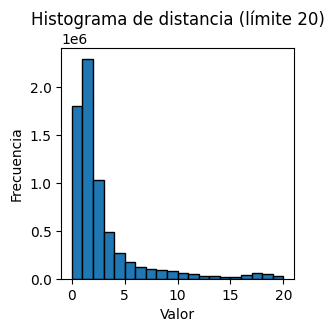

In [120]:
outliers_distancia(20)


Columna: distancia

Modal: 0.8                      Promedio: 2.94                     Mediana: 1.6                     

Límite inferior: 0              Límite superior: 6.08              Outliers: 811775          




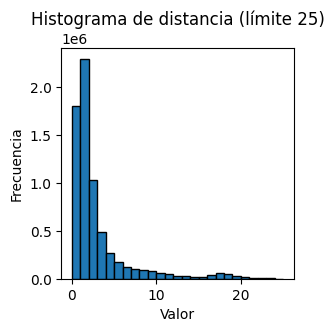

In [121]:
outliers_distancia(25)

Luego de revisar diversas fuentes para comprender mejor el contexto, entendemos que no es común tener viajes de más de 20 millas; estos viajes se realizan mediante otros medios de transporte. Además, nuestro análisis es para que una empresa de transporte de pasajeros de media y larga distancia (micros) evalúe la posibilidad de incorporar una flota de vehículos para viajes en la ciudad. Vamos a revisar el porcentaje de registros para distancias mayores a 20 millas:

In [122]:
cantidad = df_amarillos_12_19['distancia'][df_amarillos_12_19['distancia'] > 20].count()
total = len(df_amarillos_12_19)
porcentaje = round(cantidad / total * 100,2)
print(f'Total de registros: {total}    Cantidad de registros con distancia mayor a 20 millas: {cantidad}     Porcentaje: {porcentaje} %')


Total de registros: 6896293    Cantidad de registros con distancia mayor a 20 millas: 50952     Porcentaje: 0.74 %


Dado que, además de lo expuesto previamente, es un porcentaje insignificante, eliminamos los registros.

In [123]:
df_amarillos_12_19 = df_amarillos_12_19.drop(df_amarillos_12_19['distancia'][df_amarillos_12_19['distancia'] > 20].index)

### Columna 'tarifa medida'

In [124]:
df_amarillos_12_19[(df_amarillos_12_19['tarifa_medida']>0) & (df_amarillos_12_19['distancia']==0)].count()

inicio_viaje       68162
fin_viaje          68162
pasajeros          68162
distancia          68162
zona_inicio        68162
zona_fin           68162
modalidad_pago     68162
tarifa_medida      68162
propina            68162
tarifa_total       68162
recargo_trafico    68162
dtype: int64

In [125]:
df_amarillos_12_19 = df_amarillos_12_19.drop(df_amarillos_12_19[(df_amarillos_12_19['tarifa_medida']>0) & (df_amarillos_12_19['distancia']==0)].index)

In [126]:
df_amarillos_12_19 = df_amarillos_12_19.drop(df_amarillos_12_19[(df_amarillos_12_19['tarifa_medida']>300) & (df_amarillos_12_19['distancia']<20)].index)

In [127]:
df_amarillos_12_19[(df_amarillos_12_19['tarifa_medida']>100) & (df_amarillos_12_19['distancia']<5)].sample(5)

,inicio_viaje,fin_viaje,pasajeros,distancia,zona_inicio,zona_fin,modalidad_pago,tarifa_medida,propina,tarifa_total,recargo_trafico
1859950,2019-12-08 17:11:43,2019-12-08 17:26:58,1,0.23,265,265,2,150.0,0.00,150.30,0.0
4952277,2019-12-20 19:51:44,2019-12-20 19:52:11,3,0.70,265,265,1,165.0,0.00,165.30,0.0
768226,2019-12-04 14:59:20,2019-12-04 14:59:25,1,0.08,48,48,1,149.0,29.96,179.76,0.0
1088945,2019-12-05 19:03:56,2019-12-05 19:03:57,1,0.21,1,264,1,122.0,24.56,147.36,0.0
146115,2019-12-01 18:49:03,2019-12-01 18:49:08,1,0.13,138,138,1,130.0,0.00,130.80,0.0


In [128]:
df_amarillos_12_19 = df_amarillos_12_19.drop(df_amarillos_12_19[(df_amarillos_12_19['tarifa_medida']>100) & (df_amarillos_12_19['distancia']<5)].index)

In [129]:
df_amarillos_12_19['tarifa_medida'].max()

300.0

In [130]:
df_amarillos_12_19[df_amarillos_12_19['tarifa_medida'] > 100].sample(5)

,inicio_viaje,fin_viaje,pasajeros,distancia,zona_inicio,zona_fin,modalidad_pago,tarifa_medida,propina,tarifa_total,recargo_trafico
4333422,2019-12-18 16:38:30,2019-12-18 19:05:32,1,17.04,162,113,1,111.0,25.46,152.76,0.0
2295912,2019-12-10 18:56:17,2019-12-10 19:52:02,1,14.05,138,265,1,118.0,0.08,140.00,0.0
4831680,2019-12-20 11:35:20,2019-12-20 12:22:29,3,19.20,230,265,1,103.0,12.00,139.30,2.5
2038103,2019-12-09 15:25:17,2019-12-09 16:19:36,1,15.09,249,1,1,110.0,24.66,147.96,2.5
4352540,2019-12-18 17:10:32,2019-12-18 19:18:11,1,19.02,161,1,1,107.5,25.16,150.96,0.0


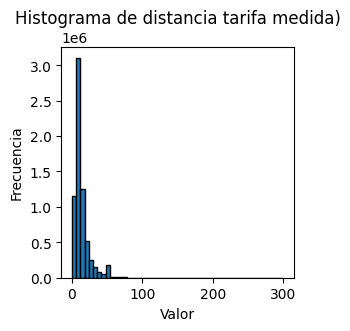

In [131]:
plt.figure(figsize=(3,3))
plt.hist(df_amarillos_12_19['tarifa_medida'][df_amarillos_12_19['tarifa_medida'] > -1], bins=50, edgecolor='black')
plt.title(f'Histograma de distancia tarifa medida)')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.show()

### Columna 'tarifa_total'

In [132]:
df_amarillos_12_19[df_amarillos_12_19['tarifa_total']> 150].sample(20)

,inicio_viaje,fin_viaje,pasajeros,distancia,zona_inicio,zona_fin,modalidad_pago,tarifa_medida,propina,tarifa_total,recargo_trafico
2950207,2019-12-13 03:06:03,2019-12-13 03:21:21,1,6.40,263,157,3,19.5,0.00,635.96,2.5
6864403,2019-12-12 14:52:00,2019-12-12 15:38:00,1,7.16,164,265,0,120.0,28.06,168.36,2.5
2049718,2019-12-09 16:09:18,2019-12-09 16:10:11,1,10.50,265,265,1,190.0,38.00,228.30,0.0
2057618,2019-12-09 17:27:22,2019-12-09 19:31:11,1,19.90,132,265,1,120.0,26.55,159.35,0.0
3071711,2019-12-13 15:11:05,2019-12-13 16:19:54,1,19.92,8,265,1,120.0,27.48,164.90,0.0
2955860,2019-12-13 05:45:34,2019-12-13 06:05:20,1,12.60,264,265,1,138.0,31.25,187.67,0.0
3071046,2019-12-13 15:17:20,2019-12-13 16:40:35,2,18.16,142,1,1,107.0,31.95,159.75,2.5
2847805,2019-12-12 19:38:48,2019-12-12 20:20:27,2,19.80,246,265,1,140.0,35.05,175.35,0.0
5363600,2019-12-22 17:11:05,2019-12-22 18:07:08,1,19.29,170,265,1,126.0,27.08,162.50,2.5
1476308,2019-12-07 08:25:19,2019-12-07 08:26:33,1,19.20,265,265,1,232.0,69.65,301.95,0.0


In [133]:
df_amarillos_12_19.shape

(6776739, 11)

Columna 'modalidad_pago'

In [134]:
df_amarillos_12_19[df_amarillos_12_19['modalidad_pago']==2].sample()

,inicio_viaje,fin_viaje,pasajeros,distancia,zona_inicio,zona_fin,modalidad_pago,tarifa_medida,propina,tarifa_total,recargo_trafico
3163530,2019-12-13 21:15:33,2019-12-13 21:21:34,1,0.32,162,162,2,5.5,0.0,9.3,2.5


In [135]:
df_amarillos_12_19['modalidad_pago'][df_amarillos_12_19['modalidad_pago'] == 2] = -1


Columna: pasajeros           

Modal: 1                        Promedio: 1.32                     Mediana: 1.0                     

Límite inferior: 1.0            Límite superior: 1.0               Outliers: 2029722         




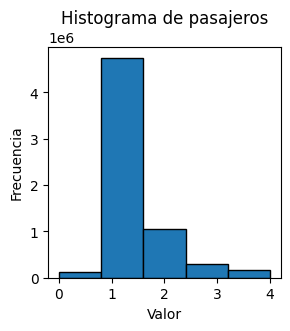

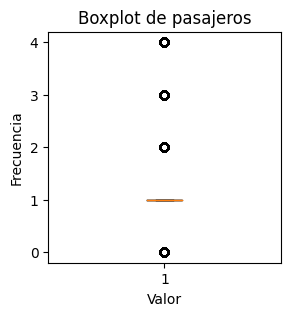







Columna: distancia           

Modal: 0.8                      Promedio: 2.86                     Mediana: 1.6                     

Límite inferior: 0              Límite superior: 6.03              Outliers: 765740          




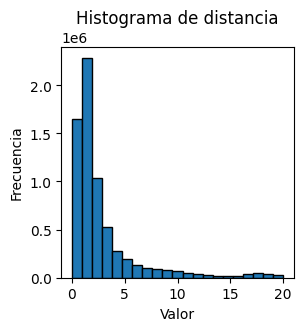

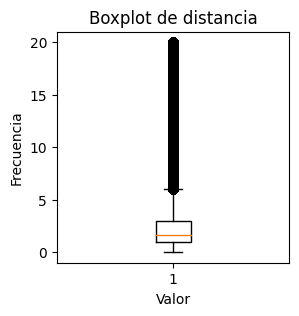







Columna: tarifa_medida       

Modal: 6.0                      Promedio: 13.04                    Mediana: 9.5                     

Límite inferior: 0              Límite superior: 27.75             Outliers: 563314          




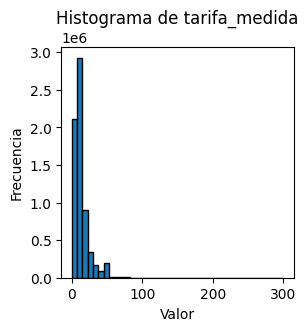

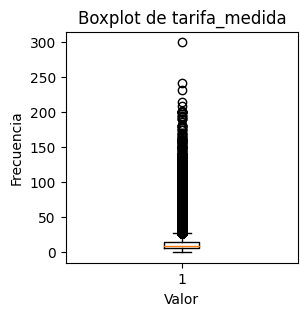







Columna: propina             

Modal: 0.0                      Promedio: 2.19                     Mediana: 1.95                    

Límite inferior: 0              Límite superior: 7.4               Outliers: 290904          




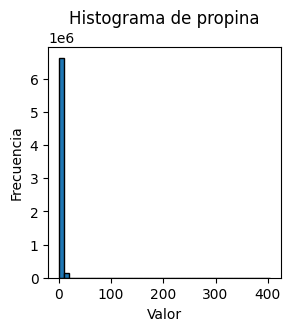

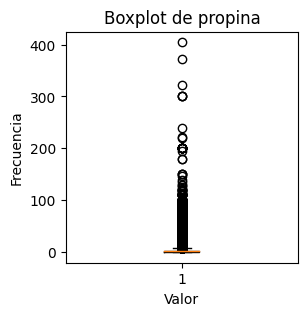







Columna: tarifa_total        

Modal: 9.8                      Promedio: 19.04                    Mediana: 14.8                    

Límite inferior: 0              Límite superior: 35.25             Outliers: 602912          




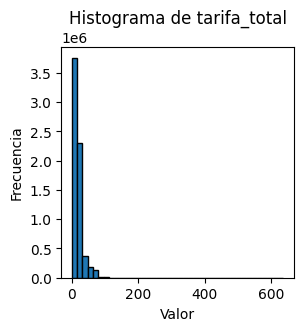

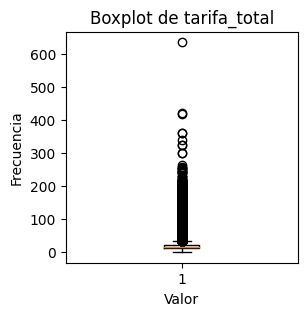







Columna: recargo_trafico     

Modal: 2.5                      Promedio: 2.33                     Mediana: 2.5                     

Límite inferior: 2.5            Límite superior: 2.5               Outliers: 470220          




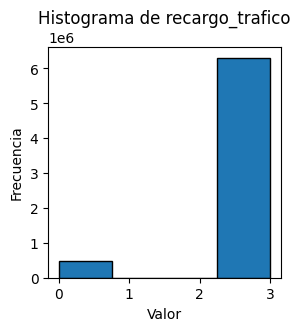

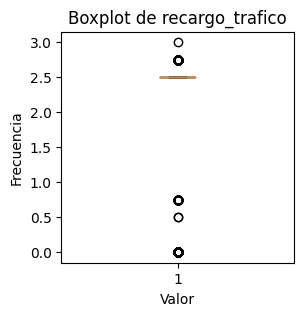

In [136]:
verificar_outliers(df_amarillos_12_19)

### Creamos columnas con horas, tiempo de viaje, días de la semana, para tener más datos para ver algún tipo de correlación.

In [186]:
df_amarillos_12_19['hora_inicio'] = df_amarillos_12_19['inicio_viaje'].dt.hour
df_amarillos_12_19['hora_fin'] = df_amarillos_12_19['fin_viaje'].dt.hour
df_amarillos_12_19['duracion_minutos'] = (df_amarillos_12_19['fin_viaje'] - df_amarillos_12_19['inicio_viaje']).dt.total_seconds() // 60
df_amarillos_12_19['duracion_minutos'] = df_amarillos_12_19['duracion_minutos'].astype(int)
df_amarillos_12_19['dia_viaje'] = df_amarillos_12_19['inicio_viaje'].dt.day_name()


In [187]:
df_amarillos_12_19.head(3)

,inicio_viaje,fin_viaje,pasajeros,distancia,zona_inicio,zona_fin,modalidad_pago,tarifa_medida,propina,tarifa_total,recargo_trafico,hora_inicio,hora_fin,duracion_minutos,dia_viaje
0,2019-12-01 00:26:58,2019-12-01 00:41:45,1,4.2,142,116,-1,14.5,0.0,18.3,2.5,0,0,14,Sunday
3,2019-12-01 00:12:03,2019-12-01 00:33:19,2,9.4,138,25,1,28.5,10.0,39.8,0.0,0,0,21,Sunday
4,2019-12-01 00:05:27,2019-12-01 00:16:32,2,1.6,161,237,-1,9.0,0.0,12.8,2.5,0,0,11,Sunday


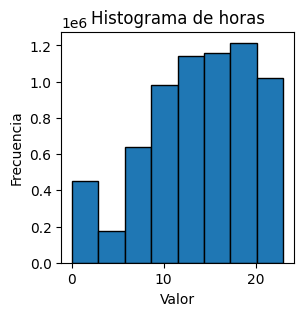

In [157]:
plt.figure(figsize=(3,3))
plt.hist(df_amarillos_12_19['hora_inicio'], bins=8, edgecolor='black')
plt.title(f'Histograma de horas')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.show()

In [170]:
df_amarillos_12_19[df_amarillos_12_19['duracion_minutos']<0].head()

,inicio_viaje,fin_viaje,pasajeros,distancia,zona_inicio,zona_fin,modalidad_pago,tarifa_medida,propina,tarifa_total,recargo_trafico,hora_inicio,hora_fin,duracion_minutos,dia_viaje
2036290,2019-12-09 15:53:10,2019-12-05 15:33:42,1,3.70,186,13,1,19.50,3.0,25.80,2.5,15,15,-5780,0
6886396,2019-12-24 16:41:10,2019-12-24 16:41:00,1,0.06,49,49,0,9.36,0.0,10.16,2.5,16,16,-1,1


In [177]:
df_amarillos_12_19[df_amarillos_12_19['duracion_minutos']>100].count()

inicio_viaje        20624
fin_viaje           20624
pasajeros           20624
distancia           20624
zona_inicio         20624
zona_fin            20624
modalidad_pago      20624
tarifa_medida       20624
propina             20624
tarifa_total        20624
recargo_trafico     20624
hora_inicio         20624
hora_fin            20624
duracion_minutos    20624
dia_viaje           20624
dtype: int64

In [178]:
df_amarillos_12_19 = df_amarillos_12_19.drop(df_amarillos_12_19[df_amarillos_12_19['duracion_minutos']<0].index)
df_amarillos_12_19 = df_amarillos_12_19.drop(df_amarillos_12_19[df_amarillos_12_19['duracion_minutos']>100].index)

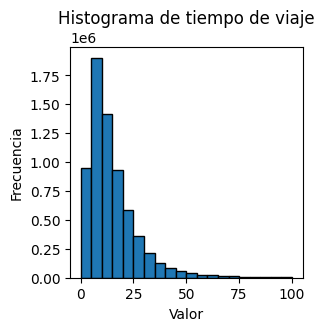

In [179]:
plt.figure(figsize=(3,3))
plt.hist(df_amarillos_12_19['duracion_minutos'], bins=20, edgecolor='black')
plt.title(f'Histograma de tiempo de viaje')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.show()

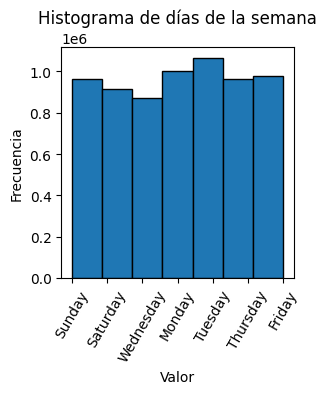

In [192]:
plt.figure(figsize=(3,3))
plt.hist(df_amarillos_12_19['dia_viaje'], bins=7, edgecolor='black')
plt.title(f'Histograma de días de la semana')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.xticks(rotation=60)
plt.show()

In [194]:
nombres_normalizados = {'inicio_viaje':'tpep_pickup_datetime', 'fin_viaje':'tpep_dropoff_datetime', 'pasajeros':'passenger_count',
                  'distancia':'trip_distance', 'zona_inicio':'pu_location_id', 'zona_fin':'do_location_id', 'tarifa_medida':'fare_amount',
                  'tarifa_total':'total_amount', 'recargo_trafico':'congestion_surcharge', 'modalidad_pago':'payment_type',
                  'propina':'tip_amount', 'hora_inicio':'star_time', 'hora_fin': 'end_time',  'duracion_minutos':'duration_minutes',
                     'dia_viaje':'trip_day'}

In [195]:
df_amarillos_12_19.rename(columns=nombres_normalizados, inplace=True)

In [197]:
df_amarillos_12_19.to_parquet(muestra_taxis_amarillos)

In [198]:
matriz = df_amarillos_12_19.corr()

In [199]:
matriz

,passenger_count,trip_distance,pu_location_id,do_location_id,payment_type,fare_amount,tip_amount,total_amount,congestion_surcharge,star_time,end_time,duration_minutes
passenger_count,1.000000,0.013095,-0.002852,-0.002803,-0.030740,0.021403,-0.006084,0.018334,0.008103,0.030522,0.030076,0.025252
trip_distance,0.013095,1.000000,-0.097148,-0.120834,0.011305,0.921812,0.510254,0.906874,-0.210416,-0.022371,-0.021419,0.771360
pu_location_id,-0.002852,-0.097148,1.000000,0.100459,0.027425,-0.091000,-0.029087,-0.078737,0.131836,0.023103,0.025575,-0.074490
do_location_id,-0.002803,-0.120834,0.100459,1.000000,0.030089,-0.113707,-0.040829,-0.101132,0.137588,0.020829,0.023739,-0.094585
payment_type,-0.030740,0.011305,0.027425,0.030089,1.000000,0.014088,0.485354,0.116917,0.093397,0.011817,0.008958,0.012379
fare_amount,0.021403,0.921812,-0.091000,-0.113707,0.014088,1.000000,0.545152,0.976120,-0.194430,0.005528,0.011610,0.846836
tip_amount,-0.006084,0.510254,-0.029087,-0.040829,0.485354,0.545152,1.000000,0.688764,-0.019943,0.024838,0.026126,0.467360
total_amount,0.018334,0.906874,-0.078737,-0.101132,0.116917,0.976120,0.688764,1.000000,-0.123805,0.019297,0.025094,0.826185
congestion_surcharge,0.008103,-0.210416,0.131836,0.137588,0.093397,-0.194430,-0.019943,-0.123805,1.000000,0.018740,0.019174,-0.065159
star_time,0.030522,-0.022371,0.023103,0.020829,0.011817,0.005528,0.024838,0.019297,0.018740,1.000000,0.935468,0.062574


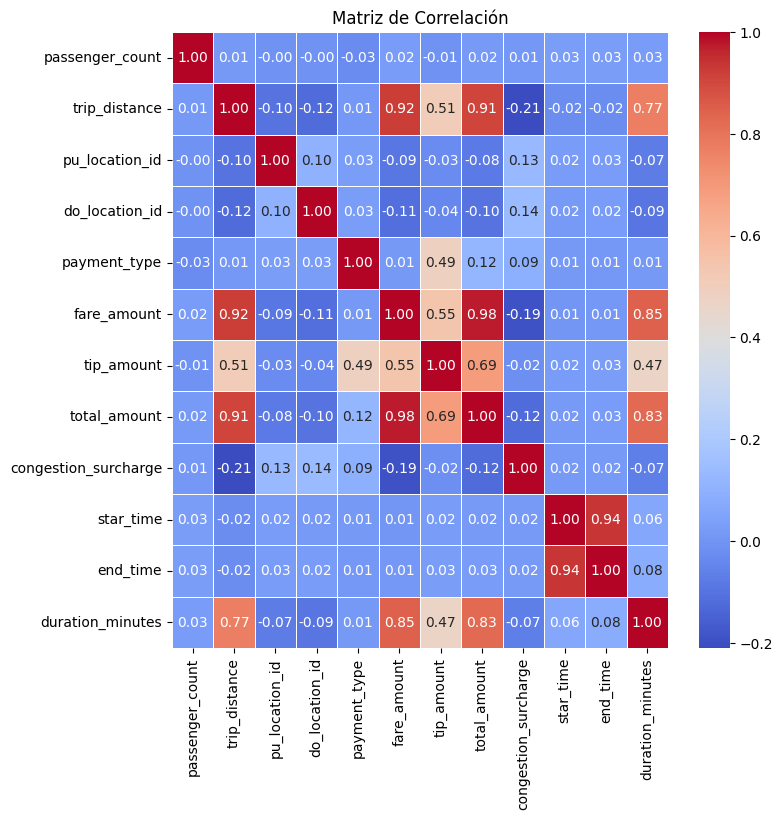

In [200]:
plt.figure(figsize=(8, 8))
sns.heatmap(matriz, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación')
plt.show()

No se observan correlaciones importantes, más allá de las obvias.